Demo target (risk next 6h) from your sample: [0.997 1.    1.    1.    1.    1.   ]


c:\Users\Mohit.gahlot\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Final losses:
SGD  - train loss: 0.001343882060609758 val loss: 0.0013483322691172361
Adam - train loss: 4.239809641148895e-05 val loss: 4.238601104589179e-05


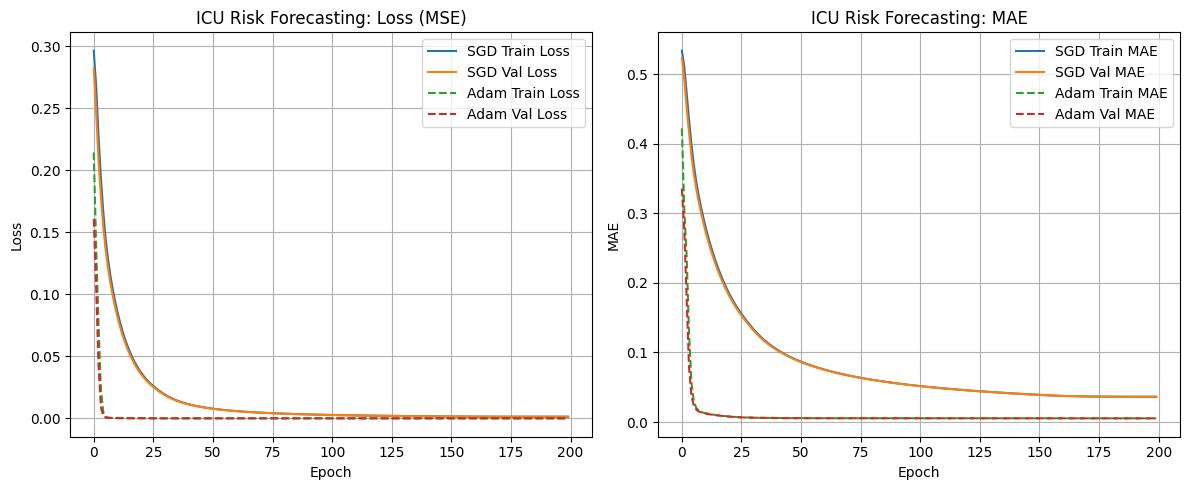


Predicted next 6h risk (SGD) : [0.965 0.968 0.969 0.958 0.959 0.961]
Predicted next 6h risk (Adam): [0.996 0.994 1.    0.993 0.99  0.992]

Last hour vitals (Hour 12):
heart_rate  : 128.0
systolic_bp : 85.0
oxygen      : 85.0
resp_rate   : 30.0
temperature : 39.0


In [1]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.random.set_seed(1)
np.random.seed(1)

# -------------------------------------------------------
# 1) Your ICU 12-hour sample data
#    (Hour, HR, BP, O2, Resp, Temp)
# -------------------------------------------------------
data = np.array([
    [1,  82, 120, 98, 16, 36.8],
    [2,  85, 118, 97, 17, 36.9],
    [3,  88, 115, 96, 18, 37.0],
    [4,  92, 112, 95, 19, 37.1],
    [5,  96, 108, 94, 20, 37.2],
    [6, 100, 105, 93, 21, 37.4],
    [7, 104, 102, 92, 22, 37.6],
    [8, 108,  98, 91, 23, 37.8],
    [9, 112,  95, 90, 24, 38.0],
    [10,118,  92, 89, 26, 38.3],
    [11,122,  88, 87, 28, 38.6],
    [12,128,  85, 85, 30, 39.0],
], dtype=np.float32)

feature_names = ["heart_rate", "systolic_bp", "oxygen", "resp_rate", "temperature"]

X_raw = data[:, 1:]  # shape (12, 5)

# -------------------------------------------------------
# 2) Create a synthetic "risk target" from your vitals
#    We create risk for next 6 hours as:
#    risk(t+k) = sigmoid( weighted sum of last-hour vitals )
#
#    This is just to make a trainable target for demo.
# -------------------------------------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def risk_from_last_hour(vitals_last):
    HR, BP, O2, Resp, Temp = vitals_last
    # Clinically-inspired direction:
    # higher HR/Resp/Temp -> higher risk
    # lower BP/O2 -> higher risk
    score = (
        0.03*(HR - 90) +
        0.05*(100 - BP) +
        0.20*(94 - O2) +
        0.08*(Resp - 20) +
        0.80*(Temp - 37.5)
    )
    base = sigmoid(score)  # 0..1

    # make a 6-hour forecast trend (slightly increasing)
    # (again: demo only)
    trend = np.linspace(0.0, 0.08, 6)
    return np.clip(base + trend, 0, 1).astype(np.float32)

y_single = risk_from_last_hour(X_raw[-1])       # shape (6,)
print("Demo target (risk next 6h) from your sample:", np.round(y_single, 3))

# -------------------------------------------------------
# 3) Build a mini dataset from ONE sample using augmentation
#    Generate many "patients" by adding small noise
# -------------------------------------------------------
def augment_sequence(seq_12x5, n=300, noise_scale=None):
    """
    seq_12x5: (12,5)
    n: number of augmented sequences
    noise_scale: per feature std deviation for noise
    """
    if noise_scale is None:
        # [HR, BP, O2, Resp, Temp] noise magnitudes
        noise_scale = np.array([2.0, 2.0, 0.5, 0.5, 0.05], dtype=np.float32)

    X_aug = []
    y_aug = []

    for _ in range(n):
        noise = np.random.normal(0, noise_scale, size=seq_12x5.shape).astype(np.float32)
        seq_noisy = seq_12x5 + noise

        # clamp to plausible ranges
        seq_noisy[:, 0] = np.clip(seq_noisy[:, 0], 40, 180)   # HR
        seq_noisy[:, 1] = np.clip(seq_noisy[:, 1], 70, 200)   # BP
        seq_noisy[:, 2] = np.clip(seq_noisy[:, 2], 70, 100)   # O2
        seq_noisy[:, 3] = np.clip(seq_noisy[:, 3], 8, 40)     # Resp
        seq_noisy[:, 4] = np.clip(seq_noisy[:, 4], 35.0, 41.0)# Temp

        # risk label derived from the noisy last hour (demo)
        y = risk_from_last_hour(seq_noisy[-1])

        X_aug.append(seq_noisy)
        y_aug.append(y)

    X_aug = np.array(X_aug, dtype=np.float32)  # (n, 12, 5)
    y_aug = np.array(y_aug, dtype=np.float32)  # (n, 6)
    return X_aug, y_aug

X_all, y_all = augment_sequence(X_raw, n=400)

# Shuffle + split
idx = np.arange(len(X_all))
np.random.shuffle(idx)
X_all, y_all = X_all[idx], y_all[idx]

train_size = int(0.8 * len(X_all))
X_train, X_val = X_all[:train_size], X_all[train_size:]
y_train, y_val = y_all[:train_size], y_all[train_size:]

# -------------------------------------------------------
# 4) Scale features based on TRAIN only (good practice)
# -------------------------------------------------------
feat_mean = X_train.reshape(-1, 5).mean(axis=0)
feat_std  = X_train.reshape(-1, 5).std(axis=0) + 1e-8

X_train_s = (X_train - feat_mean) / feat_std
X_val_s   = (X_val   - feat_mean) / feat_std

# Prepare your real single sample for prediction
X_single_s = ((X_raw - feat_mean) / feat_std).reshape(1, 12, 5)

# -------------------------------------------------------
# 5) Model builder
# -------------------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def build_model():
    model = Sequential([
        SimpleRNN(32, activation="tanh", input_shape=(12, 5)),
        Dense(32, activation="relu"),
        Dense(6, activation="sigmoid")
    ])
    return model

# Common callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5),
]

# -------------------------------------------------------
# 6) Train with SGD
# -------------------------------------------------------
model_sgd = build_model()
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.0)

model_sgd.compile(optimizer=opt_sgd, loss="mse", metrics=["mae"])
hist_sgd = model_sgd.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=callbacks
)

# -------------------------------------------------------
# 7) Train with Adam
# -------------------------------------------------------
model_adam = build_model()
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.003, clipnorm=1.0)

model_adam.compile(optimizer=opt_adam, loss="mse", metrics=["mae"])
hist_adam = model_adam.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=callbacks
)

print("\nFinal losses:")
print("SGD  - train loss:", hist_sgd.history["loss"][-1], "val loss:", hist_sgd.history["val_loss"][-1])
print("Adam - train loss:", hist_adam.history["loss"][-1], "val loss:", hist_adam.history["val_loss"][-1])

# -------------------------------------------------------
# 8) Visualization: SGD vs Adam curves
# -------------------------------------------------------
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(hist_sgd.history["loss"], label="SGD Train Loss")
plt.plot(hist_sgd.history["val_loss"], label="SGD Val Loss")
plt.plot(hist_adam.history["loss"], "--", label="Adam Train Loss")
plt.plot(hist_adam.history["val_loss"], "--", label="Adam Val Loss")
plt.title("ICU Risk Forecasting: Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(hist_sgd.history["mae"], label="SGD Train MAE")
plt.plot(hist_sgd.history["val_mae"], label="SGD Val MAE")
plt.plot(hist_adam.history["mae"], "--", label="Adam Train MAE")
plt.plot(hist_adam.history["val_mae"], "--", label="Adam Val MAE")
plt.title("ICU Risk Forecasting: MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 9) Compare predictions on YOUR 12-hour input
# -------------------------------------------------------
pred_sgd = model_sgd.predict(X_single_s, verbose=0)[0]
pred_adam = model_adam.predict(X_single_s, verbose=0)[0]

print("\nPredicted next 6h risk (SGD) :", np.round(pred_sgd, 3))
print("Predicted next 6h risk (Adam):", np.round(pred_adam, 3))

print("\nLast hour vitals (Hour 12):")
for name, val in zip(feature_names, X_raw[-1]):
    print(f"{name:12s}: {val}")
